<a align="center" href="https://hub.ultralytics.com" target="_blank">
<img width="1024", src="https://github.com/ultralytics/assets/raw/main/im/ultralytics-hub.png"></a>

<div align="center">
  <a href="https://github.com/ultralytics/hub/actions/workflows/ci.yaml">
    <img src="https://github.com/ultralytics/hub/actions/workflows/ci.yaml/badge.svg" alt="CI CPU"></a>
  <a href="https://colab.research.google.com/github/ultralytics/hub/blob/master/hub.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

Welcome to the [Ultralytics](https://ultralytics.com/) HUB notebook!

This notebook allows you to train [YOLOv5](https://github.com/ultralytics/yolov5) and [YOLOv8](https://github.com/ultralytics/ultralytics) 🚀 models using [HUB](https://hub.ultralytics.com/). Please browse the YOLOv8 <a href="https://docs.ultralytics.com">Docs</a> for details, raise an issue on <a href="https://github.com/ultralytics/hub/issues/new/choose">GitHub</a> for support, and join our <a href="https://ultralytics.com/discord">Discord</a> community for questions and discussions!
</div>

## introduction

In this project I transfered learning a medium YOLOv8 model (YOLOv8m) and trained it on a small custome dataset of about 40 images.

I annotate the dataset and use ultralytics to train the YOLOv8 model. The model is saved in two formats, PyTorch(.pt) and ONNX(.onnx) and predictions are made using both.

The model is then tested on a unlabelled set and I visually checked the results.

## The ultimate goal of this project is to deploy this model on an actual automation line for robot pick and place.


In [1]:
#let's start by installing the ultralytics library and import the necessary classes

%pip install ultralytics  # install
from ultralytics import YOLO, checks, hub
checks()  # checks

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/78.2 GB disk)


# Start

My dataset is on my google drive so I have to mount the drive to colab to be able to train the model on my dataset.

In [2]:
# mount my google drive in colab

from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


I already have trained my model using the ultralytics web interface and already deployed my model in two .pt and .onnx formats.

**One thing I noticed here is that importing and using the pytorch model and making prediction with it is more intuitive and easier than the onnx model.**

In [3]:
# let's load in the saved model from google drive

model = YOLO("/content/gdrive/MyDrive/Computer Vision/YOLOV8/Bottles/Bottles.pt") #load in the PyTorch model in


Now is time to test the trained model on an unlabelled set of images to see the results of how accurate the model is.

*Note that this object detector is only required to detect only one class of objects.

In [3]:
from logging import exception
from os.path import isdir
from PIL import Image
import os


Root_Dir = "/content/gdrive/MyDrive/Computer Vision/YOLOV8/Bottles" #my root directory in my drive
unlabelled = os.path.join(Root_Dir,"unlabelled") #the unlabelled directory
unlabelled_labelled_pt = os.path.join(Root_Dir,"unlabelled_labelled_pt") #the labelled results

In [ ]:
#this is a little script that loads the unlabelled images
#predicts the objects and saves them in another directory
try:
  if not os.path.isdir(unlabelled_labelled_pt):
    os.mkdir(unlabelled_labelled_pt) #make the directory if it is not there

  for img_path in os.listdir(unlabelled):
    results = model.predict(os.path.join(unlabelled,img_path),imgsz = 640, conf = 0.8) #predict the image with the model

    for i,r in enumerate(results):
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = Image.fromarray(im_array,'RGB')  # RGB PIL image
        im.save(os.path.join(unlabelled_labelled_pt,img_path)) #save the results with overlay

except ValueError:
  print(f"There is no such File or Directory such as {Root_Dir}")

just show one example of how the model performed on some unseen cases

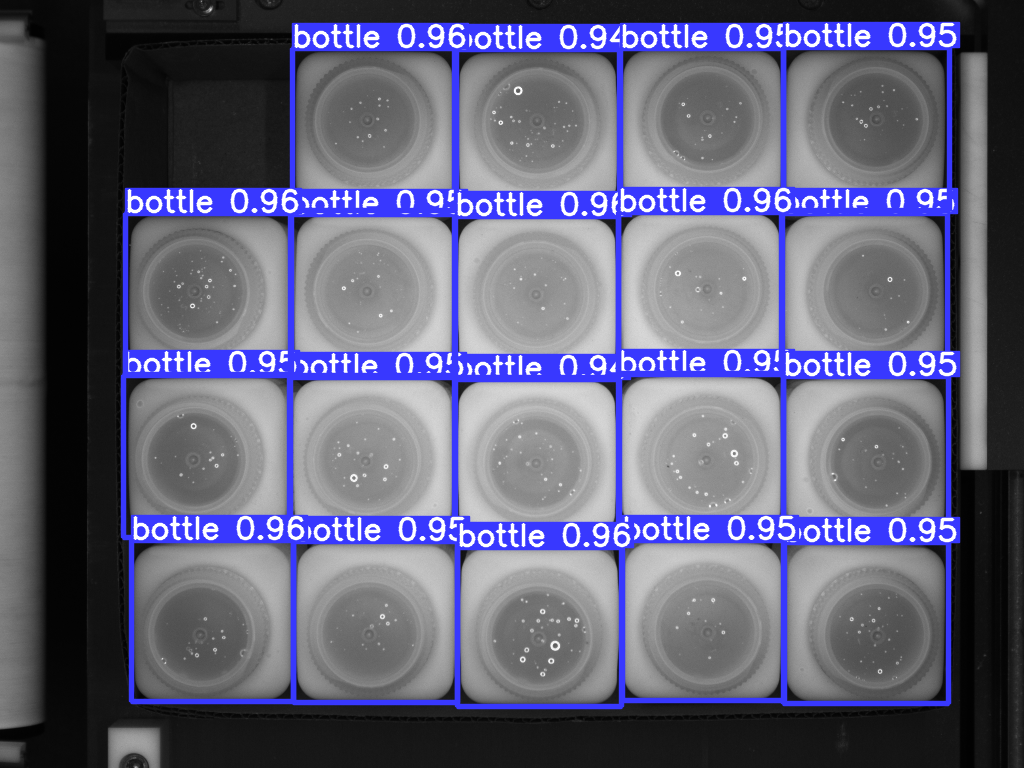

In [22]:
#now I just show one of the unseen pictures that the model predicted
import cv2
from google.colab.patches import cv2_imshow


for dir,_,files in os.walk(unlabelled_labelled_pt):
  img = cv2.imread(os.path.join(dir,files[0]))
  cv2_imshow(img)

The previous section of the code uses the pytorch model and the predictions and using the models are easier and faster in colab.
However, the power of onnx models are that you can convert them to any models and increases the compatibility of the model with different systems. Additionally, due to the approximations made during conversion in onnx models the computational time assumes to be lower which would benefit my case for deploying this model on an automation line even more.

Therefore, I try to import and predict the same set of images with the onnx model as well.

In [4]:
# first let's install onnxruntime
# Since I am processing an image I would assume that gpu processing will speed up my process
# I will have to try the cpu and check the runtime to make sure
!pip install onnxruntime-gpu
!pip install torch # since some of the onnx libraries(onnx) are in the torch library
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 86.3 MB/s eta 0:00:00


In [5]:
import onnx
import onnxruntime as ort
import numpy as np
import cv2

onnx_model = onnx.load(os.path.join(Root_Dir,"Bottles.onnx")) # load in the onnx model
print(onnx.checker.check_model(onnx_model))# to Check the consistency of a model. None means there is no exceptions and everything is good

None


In [6]:
#create a onnxruntime session
ort_sess = ort.InferenceSession("/content/gdrive/MyDrive/Computer Vision/YOLOV8/Bottles/Bottles.onnx",providers=ort.get_available_providers())

EP Error /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1193 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_tensorrt.so with error: libnvinfer.so.8: cannot open shared object file: No such file or directory
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.


A great way to get know what the input and output of a onnx model looks like is the two cells below.

I use the next two cells, which you can find on the onnxruntime [webpage]("https://onnxruntime.ai/docs/api/python/auto_examples/plot_load_and_predict.html"), to manipulate the unlabelled images and process them with my model.

In [7]:
# let's get the name, shape and type of our inputs
input_name = ort_sess.get_inputs()[0].name
print("input name", input_name)
input_shape = ort_sess.get_inputs()[0].shape
print("input shape", input_shape)
input_type = ort_sess.get_inputs()[0].type
print("input type", input_type)

input name images
input shape [1, 3, 640, 640]
input type tensor(float)


In [8]:
# let's see what to expect as our outputs
output_name = ort_sess.get_outputs()[0].name
print("output name", output_name)
output_shape = ort_sess.get_outputs()[0].shape
print("output shape", output_shape)
output_type = ort_sess.get_outputs()[0].type
print("output type", output_type)

output name output0
output shape [1, 5, 8400]
output type tensor(float)


Now that I know what the input to my onnx model should be like I will import and manipulate the image to feed into my onnx model.

In [13]:
#let's read in the image and massage it into the shape that our model can take
import cv2
from google.colab.patches import cv2_imshow

for dir,_,files in os.walk(unlabelled_labelled_pt):
  img = cv2.imread(os.path.join(dir,files[0])) #load in the first image from the unlabelled directory
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (640,640), interpolation=cv2.INTER_AREA) #resize the image to the input shape of the model
  img = np.expand_dims(img,axis=0).astype(np.float32)/255. #expand the dimensions of the image
  img = np.transpose(img,[0,3,1,2]) #reshape the image into the shape that the model can take
  outputs = ort_sess.run(None,{input_name: img}) #run the model and predict the outputs

image = outputs[0]
print(image.shape)

(1, 5, 8400)
